# 📚 **Installation**

In [1]:
import bz2
import time
import mlflow
import joblib
import optuna
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import optuna.visualization as ov
from bokeh.io import export_svgs
from bokeh.layouts import row, gridplot
from bokeh.plotting import figure, show
from bokeh.palettes import viridis, cividis
from bokeh.models import ColumnDataSource, Range1d
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import StackingRegressor, GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor, HistGradientBoostingRegressor
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict, cross_val_score
from textwrap import wrap
from matplotlib.cm import get_cmap
# from optuna.exceptions import TrialPruned

import ipywidgets
import mlflow.sklearn
from optuna.integration import MLflowCallback
from sklearn.experimental import enable_hist_gradient_boosting

from tqdm import tqdm
from mlflow.tracking import MlflowClient

from bokeh.palettes import viridis, cividis
viridis_palette = viridis(256)

import mlflow
import mlflow.sklearn
from urllib.parse import urlparse, unquote
import os

# pip install optimizingutils-1.84-py2.py3-none-any.whl

from OptimizingUtils.tunePipeline import tunePipeline as tp

C:\Users\decla\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:15: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


# ⚠️ **Warnings**

In [2]:
import logging
import warnings
logging.basicConfig(level=logging.INFO)
logging.disable(logging.WARNING)
optuna.logging.disable_default_handler()
pd.options.mode.chained_assignment = None 
optuna.logging.set_verbosity(optuna.logging.ERROR)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# 📂 **Data**

In [3]:
# Create a DataFrame from CSV data
result_df = pd.read_csv("FE_golf.csv")

# 🍽️ **Pre-Processing**

In [4]:
# Assume result_df is already defined and preprocessed up to this point
result_df = result_df[result_df['from_location_scorer'] != 'Green']

categorical_cols = ['round', 
                    'par_value', 
                    'lie',
                    'slope', 
                    'elevation', 
                    'non_putting_dist_from_center_bins',
                    'non_putting_dist_from_edge_bins',
                    'non_putting_distance_to_pin_bins', 
                    'around_the_green',
                    'side_of_hole', 
                    'dog_legs', 
                    'HCP',
                    'shot_type',
                    'from_location_scorer', 
                    'from_location_laser']

numerical_cols = ["ISS", 
                  "ISC", 
                  "SSI", 
                  "CSI",
                  "shot",
                  "distance_to_pin",
                  "dist_from_edge",
                  "dist_from_center",
                  "pin_minus_edge", 
                  "Actual Yard",
                  "yardage",
                  "hole_completeness"]

# Feature columns and target column
feature_cols = categorical_cols + numerical_cols

# 🔪 **Split**

In [5]:
X = result_df[feature_cols]
y = result_df['strokes_to_hole_out']

# Extract the columns for stratification
stratify_cols = ['non_putting_dist_from_center_bins','non_putting_distance_to_pin_bins','par_value']

#stratify_cols = ['non_putting_distance_to_pin_bins']
stratify_data = result_df[stratify_cols]

# Split the data, using 'stratify_data' for stratification
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=42, stratify=stratify_data)

# 🔄 **MLFlow**

Navigate to the terminal and create an MLFlow instance:

``` console

mlflow server --backend-store-uri sqlite:///mlflow.db --default-artifact-root ./mlruns --host 0.0.0.0 --port 8080

```

In [6]:
mlflow.set_tracking_uri("http://localhost:8080")

# Custom prunce & Sampler for Optuna
pruner = optuna.pruners.MedianPruner()
sampler = optuna.samplers.CmaEsSampler()

#amount of trials per model
trials_todo = 50

base_models = []

# 🎶🎷 **Tune Base GradientBoostingRegressor**

In [7]:
experiment_name = "Approach v1 GradientBoostingRegressor Base"
mlflow.set_experiment(experiment_name)
GradientBoostingRegressor_study = optuna.create_study(direction='minimize', sampler=sampler, pruner=pruner)

# Define a function to suggest hyperparameters for GradientBoostingRegressor
def gradient_boosting_params(trial):
    return {
        "n_estimators": trial.suggest_int("n_estimators", 150, 600),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.005, 0.05),
        "max_depth": trial.suggest_int("max_depth", 3, 7),
        "subsample": trial.suggest_uniform("subsample", 0.4, 0.8),
        "min_samples_split": trial.suggest_int("min_samples_split", 4, 8),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 3, 7),
        "max_features": trial.suggest_uniform("max_features", 0.4, 0.99),
    }

with tqdm(total=trials_todo) as pbar:
    def update_progress(GradientBoostingRegressor_study, trial):
        pbar.update(1)

    # Use the objective function with the GradientBoostingRegressor
    #strat_col='putting_distance_to_pin_bins'
    GradientBoostingRegressor_study.optimize(lambda trial: tp.objective(trial, 
                                                                        GradientBoostingRegressor, 
                                                                        gradient_boosting_params,
                                                                        categorical_cols=categorical_cols, 
                                                                        numerical_cols=numerical_cols, 
                                                                        X=X, 
                                                                        y=y,
                                                                        strat_col='non_putting_distance_to_pin_bins'), 
                                                n_trials=trials_todo, 
                                                n_jobs=-1,
                                                show_progress_bar=True, 
                                                callbacks=[update_progress])

# log and register best model to prod
best_model = tp.get_best_model(experiment_name)
base_models.append(best_model)
best_model

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [06:20<00:00,  7.62s/it]


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MaxAbsScaler())]),
                                                  ['ISS', 'ISC', 'SSI', 'CSI',
                                                   'shot', 'distance_to_pin',
                                                   'dist_from_edge',
                                                   'dist_from_center',
                                                   'pin_minus_edge',
                                                   'Actual Yard', 'yardage',
                                                   'hole_completeness']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleIm...
                                                 ('feature_selector',
                                                  SelectKBest(k=12,
                                                              score_func=<function f_regression at 0x0000022536B1E0D0>),
                                                  []),
                                                 ('poly',
                                                  PolynomialFeatures(degree=3,
                                                                     include_bias=False),
                                                  [])])),
                ('regressor',
                 GradientBoostingRegressor(learning_rate=0.013929692043446042,
                                           max_features=0.7410280933316773,
                                           min_samples_leaf=3,
                                           min_samples_split=5,
                                           n_estimators=592, random_state=42,
                                           subsample=0.6352782823875556))])

In [8]:
ov.plot_optimization_history(GradientBoostingRegressor_study)

In [9]:
ov.plot_param_importances(GradientBoostingRegressor_study)

In [10]:
ov.plot_contour(GradientBoostingRegressor_study, params=["encoder", "scaler"])

# 🎶🎷 **Tune Base AdaBoostRegressor**

In [11]:
experiment_name = "Approach v1 AdaBoostRegressor_Base_Model"
mlflow.set_experiment(experiment_name)
AdaBoostRegressor_study = optuna.create_study(direction='minimize', sampler=sampler, pruner=pruner)

# Define a function to suggest hyperparameters for AdaBoostRegressor
def AdaBoostRegressorg_params(trial):
    return {
        "n_estimators": trial.suggest_int("n_estimators", 20, 600),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
    }

with tqdm(total=trials_todo) as pbar:
    def update_progress(AdaBoostRegressor_study, trial):
        pbar.update(1)

    # Use the objective function with the AdaBoostRegressor
    AdaBoostRegressor_study.optimize(lambda trial: tp.objective(trial, 
                                                                AdaBoostRegressor, 
                                                                AdaBoostRegressorg_params, 
                                                                categorical_cols=categorical_cols, 
                                                                numerical_cols=numerical_cols, 
                                                                X=X, 
                                                                y=y,
                                                                strat_col='non_putting_distance_to_pin_bins'), 
                                        n_trials=trials_todo, 
                                        n_jobs=-1, 
                                        show_progress_bar=True, 
                                        callbacks=[update_progress])

# log and register best model to prod
best_model = tp.get_best_model(experiment_name)
base_models.append(best_model)
best_model

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [04:08<00:00,  4.97s/it]


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['ISS', 'ISC', 'SSI', 'CSI',
                                                   'shot', 'distance_to_pin',
                                                   'dist_from_edge',
                                                   'dist_from_center',
                                                   'pin_minus_edge',
                                                   'Actual Yard', 'yardage',
                                                   'hole_completeness']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleIm...
                                                   'non_putting_dist_from_center_bins',
                                                   'non_putting_dist_from_edge_bins',
                                                   'non_putting_distance_to_pin_bins',
                                                   'around_the_green',
                                                   'side_of_hole', 'dog_legs',
                                                   'HCP', 'shot_type',
                                                   'from_location_scorer',
                                                   'from_location_laser']),
                                                 ('poly',
                                                  PolynomialFeatures(degree=3,
                                                                     include_bias=False),
                                                  [])])),
                ('regressor',
                 AdaBoostRegressor(learning_rate=0.0032504467062119597,
                                   n_estimators=56, random_state=42))])

In [12]:
ov.plot_optimization_history(AdaBoostRegressor_study)

In [13]:
ov.plot_param_importances(AdaBoostRegressor_study)

In [14]:
ov.plot_contour(AdaBoostRegressor_study, params=["encoder", "scaler"])

# 🎶🎷 **Tune Base RandomForestRegressor**

In [15]:
experiment_name = "Approach v1 RandomForestRegressor_Base_Model_v2"
mlflow.set_experiment(experiment_name)
RandomForestRegressor_study = optuna.create_study(direction='minimize', sampler=sampler, pruner=pruner)

# Define a function to suggest hyperparameters for RandomForestRegressor
def RandomForestRegressor_params(trial):
    return {
        "n_estimators": trial.suggest_int("n_estimators", 200, 600),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "max_features": trial.suggest_uniform("max_features", 0.1, 1.0),
    }

with tqdm(total=trials_todo) as pbar:
    def update_progress(RandomForestRegressor_study, trial):
        pbar.update(1)

    # Use the objective function with the RandomForestRegressor
    RandomForestRegressor_study.optimize(lambda trial: tp.objective(trial, 
                                                                    RandomForestRegressor, 
                                                                    RandomForestRegressor_params,
                                                                    categorical_cols=categorical_cols, 
                                                                    numerical_cols=numerical_cols, 
                                                                    X=X, 
                                                                    y=y,
                                                                    strat_col='non_putting_distance_to_pin_bins'), 
    n_trials=trials_todo,
    n_jobs=-1, 
    callbacks=[update_progress])

# log and register best model to prod
best_model = tp.get_best_model(experiment_name)
base_models.append(best_model)
best_model

100%|██████████| 50/50 [07:18<00:00,  8.78s/it]


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   QuantileTransformer(n_quantiles=489,
                                                                                       output_distribution='normal'))]),
                                                  ['ISS', 'ISC', 'SSI', 'CSI',
                                                   'shot', 'distance_to_pin',
                                                   'dist_from_edge',
                                                   'dist_from_center',
                                                   'pin_minus_edge',
                                                   'Actual Yard', 'yardage',
                                                   'hole_complet...
                                                   'side_of_hole', 'dog_legs',
                                                   'HCP', 'shot_type',
                                                   'from_location_scorer',
                                                   'from_location_laser']),
                                                 ('feature_selector',
                                                  SelectFromModel(estimator=GradientBoostingRegressor(n_estimators=50)),
                                                  []),
                                                 ('poly',
                                                  PolynomialFeatures(include_bias=False),
                                                  [])])),
                ('regressor',
                 RandomForestRegressor(max_depth=7,
                                       max_features=0.23742751562873077,
                                       min_samples_leaf=4, n_estimators=590,
                                       random_state=42))])

In [16]:
ov.plot_optimization_history(RandomForestRegressor_study)

In [17]:
ov.plot_param_importances(RandomForestRegressor_study)

In [18]:
ov.plot_contour(RandomForestRegressor_study, params=["encoder", "scaler"])

# 🎶🎷 **Tune Base MLPRegressor**

In [19]:
experiment_name = "Approach v1 MLPRegressor_Base_Model"  
mlflow.set_experiment(experiment_name)
MLPRegressor_study = optuna.create_study(direction='minimize', sampler=sampler, pruner=pruner)

# Define a function to suggest hyperparameters for MLPRegressor_params_study
def MLPRegressor_params(trial):
    return {
        "hidden_layer_sizes": trial.suggest_int("hidden_layer_sizes", 1, 100),
        "alpha": trial.suggest_loguniform("alpha", 1e-6, 1.0),
        "learning_rate_init": trial.suggest_loguniform("learning_rate_init", 1e-7, 1e-1),
        "max_iter": trial.suggest_int("max_iter", 100, 1000),
    }

with tqdm(total=trials_todo) as pbar:
    def update_progress(MLPRegressor_study, trial):
        pbar.update(1)

    # Use the objective function with the best_MLPRegressor_model
    MLPRegressor_study.optimize(lambda trial: tp.objective(trial, 
                                                            MLPRegressor, 
                                                            MLPRegressor_params,
                                                            categorical_cols=categorical_cols, 
                                                            numerical_cols=numerical_cols, 
                                                            X=X, 
                                                            y=y,
                                                            strat_col='non_putting_distance_to_pin_bins'), 
                                n_trials=trials_todo,
                                n_jobs=-1, 
                                callbacks=[update_progress])

# log and register best model to prod
best_model = tp.get_best_model(experiment_name)
base_models.append(best_model)
best_model

100%|██████████| 50/50 [26:16<00:00, 31.54s/it]  


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['ISS', 'ISC', 'SSI', 'CSI',
                                                   'shot', 'distance_to_pin',
                                                   'dist_from_edge',
                                                   'dist_from_center',
                                                   'pin_minus_edge',
                                                   'Actual Yard', 'yardage',
                                                   'hole_completeness']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   Simple...
                                                   'non_putting_distance_to_pin_bins',
                                                   'around_the_green',
                                                   'side_of_hole', 'dog_legs',
                                                   'HCP', 'shot_type',
                                                   'from_location_scorer',
                                                   'from_location_laser']),
                                                 ('poly',
                                                  PolynomialFeatures(degree=3,
                                                                     include_bias=False),
                                                  [])])),
                ('regressor',
                 MLPRegressor(alpha=0.06069205935512005, hidden_layer_sizes=86,
                              learning_rate_init=0.00012165799649977705,
                              max_iter=232, random_state=42))])

In [20]:
ov.plot_optimization_history(MLPRegressor_study)

In [21]:
ov.plot_param_importances(MLPRegressor_study)

In [22]:
ov.plot_contour(MLPRegressor_study, params=["encoder", "scaler"])

# 🚂 **Train Final Estimator** 🤖

In [23]:
names = ['Base GradientBoostingRegressor','Base AdaBoostRegressor','Base RandomForestRegressor', 'Base MLPRegressor']
pairs = list(zip(names, base_models))

experiment_name = "Approach_v1_Final_Estimator_Model"
mlflow.set_experiment(experiment_name)
final_estimator_study = optuna.create_study(direction='minimize', sampler=sampler, pruner=pruner)

# Define a function to suggest hyperparameters for final_estimator
def final_estimator_params(trial):
    return {
        "n_estimators": trial.suggest_int("n_estimators", 150, 600),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.005, 0.05),
        "max_depth": trial.suggest_int("max_depth", 3, 7),
        "subsample": trial.suggest_uniform("subsample", 0.4, 0.8),
        "min_samples_split": trial.suggest_int("min_samples_split", 4, 8),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 3, 7),
        "max_features": trial.suggest_uniform("max_features", 0.4, 0.99),
    }

with tqdm(total=trials_todo) as pbar:
    def update_progress(final_estimator_study, trial):
        pbar.update(1)

    # Optimize the StackingRegressor
    final_estimator_study.optimize(
        lambda trial: tp.objective(
            trial, 
            GradientBoostingRegressor, 
            final_estimator_params, 
            is_stacking=True, 
            base_models=pairs,
            categorical_cols=categorical_cols, 
            numerical_cols=numerical_cols, 
            X=X,   
            y=y,
            strat_col='non_putting_distance_to_pin_bins'
        ),
        n_jobs=-1,
        n_trials=trials_todo,
        callbacks=[update_progress] 
    )

best_model = tp.get_best_model(experiment_name)
best_model
 

100%|██████████| 50/50 [4:44:15<00:00, 341.10s/it]     


StackingRegressor(estimators=[('Base GradientBoostingRegressor',
                               Pipeline(steps=[('preprocessor',
                                                ColumnTransformer(transformers=[('num',
                                                                                 Pipeline(steps=[('imputer',
                                                                                                  SimpleImputer(strategy='median')),
                                                                                                 ('scaler',
                                                                                                  MaxAbsScaler())]),
                                                                                 ['ISS',
                                                                                  'ISC',
                                                                                  'SSI',
                                                                                  'CSI',
                                                                                  'shot',
                                                                                  'distance_to_pin',
                                                                                  'dist_from_edge',
                                                                                  'dist_from_center',
                                                                                  'pin_minus_edge',
                                                                                  'Actual '
                                                                                  'Yard',
                                                                                  'yardage'...
                                               ('regressor',
                                                MLPRegressor(alpha=0.06069205935512005,
                                                             hidden_layer_sizes=86,
                                                             learning_rate_init=0.00012165799649977705,
                                                             max_iter=232,
                                                             random_state=42))]))],
                  final_estimator=GradientBoostingRegressor(learning_rate=0.007207459100537512,
                                                            max_features=0.5558668605597843,
                                                            min_samples_leaf=5,
                                                            min_samples_split=5,
                                                            n_estimators=506,
                                                            random_state=42,
                                                            subsample=0.585899800004821))

In [24]:
ov.plot_optimization_history(final_estimator_study)  

In [25]:
ov.plot_param_importances(final_estimator_study)

In [26]:
ov.plot_contour(final_estimator_study, params=["encoder", "scaler"])

# **Mean Absolute Error**

In [27]:
# Make predictions on the validation data
preds = best_model.predict(X_valid)
#preds = base_models[0].predict(X_valid)

# Extract the predicted distances
predicted_distance = list(preds)
actual_distance = y_valid.to_list()

mae = mean_absolute_error(actual_distance, predicted_distance)
print("Mean Absolute Error:", mae)

Mean Absolute Error: 0.40820760144678986


# **Partial Dependence Display**

In [28]:
# # Filter the data
# X_train_filtered = X_train[X_train['first_putt'] == 'Y']
# # X_train_filtered = X_train_filtered[X_train_filtered['distance_to_pin'] < 2]
# # X_train_filtered = X_train_filtered[X_train_filtered['dist_from_center'] < 2]

# # Plot both features together
# f_names = [('dist_from_center', 'distance_to_pin')]
# disp = PartialDependenceDisplay.from_estimator(best_final_estimator_model, X_train_filtered[:88], f_names)
# plt.figure(figsize=(8, 6))

# **Residuals**

In [29]:
final_pipe_results = pd.DataFrame()

final_pipe_results['predicted_distance'] = predicted_distance

final_pipe_results['actual_distance'] = actual_distance

final_pipe_results['residual'] = final_pipe_results['actual_distance'] - final_pipe_results['predicted_distance']

p = figure(height=300, width=300,title="Predicted vs Actual")
p.circle(actual_distance, predicted_distance, size=5, line_color=viridis_palette[180], fill_color=viridis_palette[180], fill_alpha=0.3)
p.xaxis.axis_label = 'Actual'
p.yaxis.axis_label = 'Predicted'

z = figure(height=300, width=300,title="Predicted vs Residual")
z.circle(final_pipe_results.residual, final_pipe_results.predicted_distance, size=5, line_color=viridis_palette[180], fill_color=viridis_palette[180], fill_alpha=0.3)
z.yaxis.axis_label = 'Predicted'
z.xaxis.axis_label = 'Residual'

b = figure(width=600, height=300, toolbar_location=None,
           title="Normality of Residuals")

# Histogram
bins = np.linspace(-0.5, 0.5, 100)
hist, edges = np.histogram(final_pipe_results.residual, density=True, bins=bins)
b.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
         fill_color=viridis_palette[180], line_color="white")

b.y_range.start = 0
b.x_range.start = -0.5
b.x_range.end = 0.5

b.xaxis.axis_label = "Residuals"
b.yaxis.axis_label = "Distribution Count"

grid = gridplot([[row(p,z)], 
                 [b]])
show(grid)

# **[Permutaion Importance](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html)**

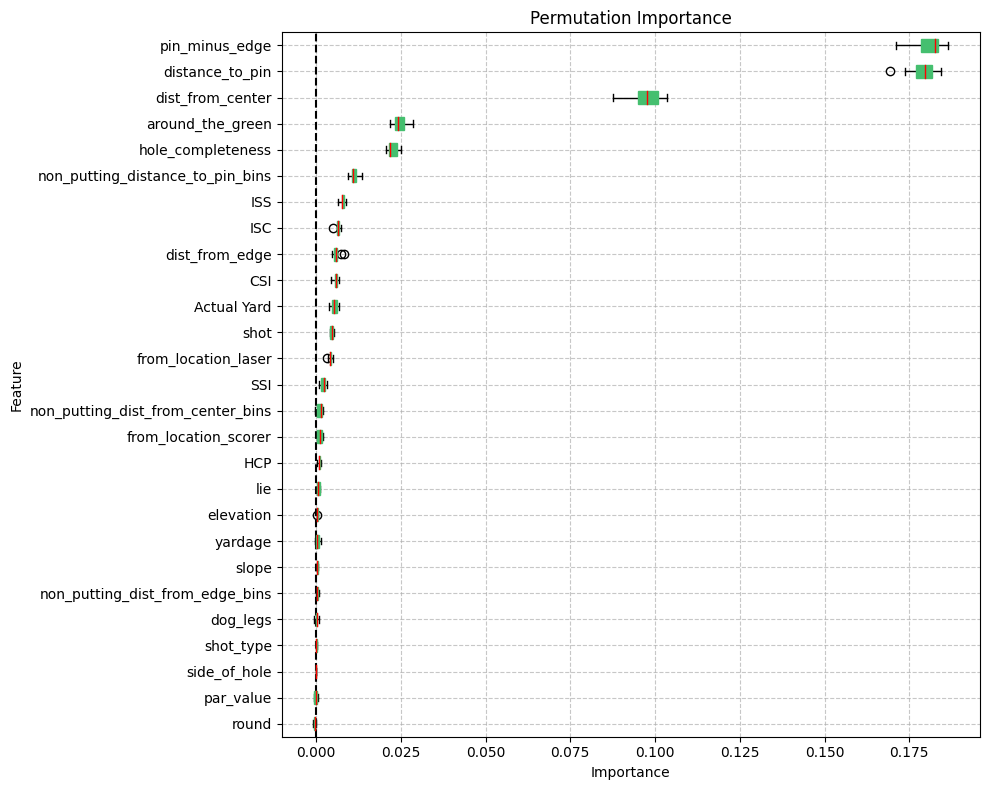

In [30]:
result = permutation_importance(best_model, 
                                X_train, 
                                y_train.values.ravel(), 
                                n_repeats=10,
                                random_state=42)

fig, ax = plt.subplots(figsize=(10, 8))  # Adjust size for better readability and aesthetics

perm_sorted_idx = result.importances_mean.argsort()

# Customize boxplot appearance
box = ax.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    patch_artist=True,  # Enable filling colors
    boxprops=dict(facecolor=viridis_palette[180], color=viridis_palette[180]),  # Box color customization
    whiskerprops=dict(color='black'),  # Whisker color customization
    capprops=dict(color='black'),  # Cap color customization
    medianprops=dict(color='red')  # Median line color customization
)

# Set labels and title
ax.set_yticklabels(X_train.columns[perm_sorted_idx])
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')
ax.set_title('Permutation Importance')

# Add a grid for better readability
ax.grid(True, linestyle='--', alpha=0.7)

# Add a vertical line at x=0
ax.axvline(x=0, color="black", linestyle="--")

# Customize layout
plt.tight_layout()

plt.show()

# 📩 **Save**

In [31]:
with bz2.BZ2File('approachModel.joblib.bz2', 'wb', compresslevel=9) as f:
    joblib.dump(best_model, f)